
=== Simulation : Schw (b=2) [a=-0.4, Q=0.8, b=2.0] ===
Calcul FDFD en cours...
Construction matrice (2100x2100)...
Résolution...
Calcul de la trajectoire moyenne de Poynting...


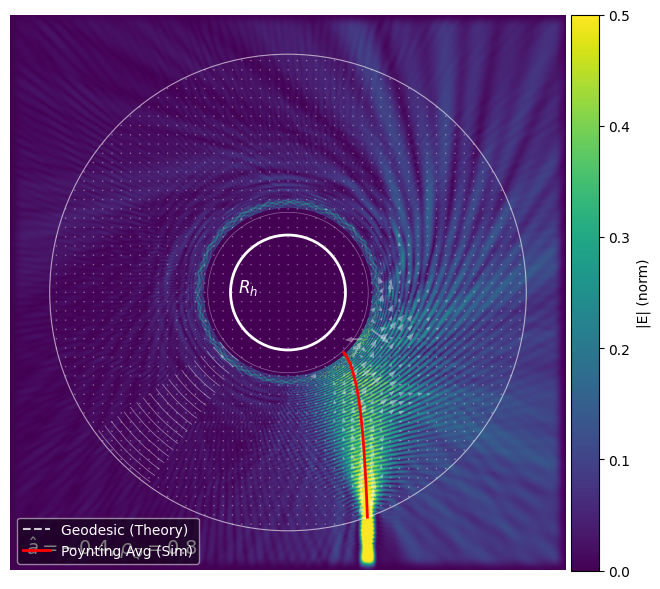

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator 

# --- Global Constants ---
LAMBDA_0 = 0.5
K0 = 2 * np.pi / LAMBDA_0
R_SCHWARZSCHILD = 5.0
MASS_M = R_SCHWARZSCHILD / 2.0

class MaxwellFDFD:
    def __init__(self, L, resolution, pml_width):
        self.L = L
        self.resolution = resolution
        self.dx = 1.0 / (resolution)
        self.Nx = int(L * resolution)
        self.Ny = int(L * resolution)
        self.shape = (self.Nx, self.Ny)
        self.npml = int(pml_width * resolution)

        self.x = np.linspace(-L/2, L/2, self.Nx)
        self.y = np.linspace(-L/2, L/2, self.Ny)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.epsilon = np.ones(self.shape, dtype=np.complex128)
        self.source = np.zeros(self.shape, dtype=np.complex128)

    def _make_derivative_matrices(self, N):
        e = np.ones(N)
        D = sp.spdiags([-e, e], [0, 1], N, N) / self.dx
        return D

    def _create_pml_stretch(self, N, npml):
        sigma = np.zeros(N)
        if npml > 0:
            idx = np.arange(npml)
            prof = (idx / npml) ** 2
            sigma[0:npml] = prof[::-1]
            sigma[-npml:] = prof
        return 1.0 + 1j * sigma

    def get_poynting_vector(self, Ez):
        Dx_1d = self._make_derivative_matrices(self.Nx)
        Dy_1d = self._make_derivative_matrices(self.Ny)
        Dx_cent = 0.5 * (Dx_1d - Dx_1d.transpose())
        Dy_cent = 0.5 * (Dy_1d - Dy_1d.transpose())
        Op_diff_x = sp.kron(Dx_cent, sp.eye(self.Ny))
        Op_diff_y = sp.kron(sp.eye(self.Nx), Dy_cent)
        Ez_flat = Ez.flatten()
        dEz_dx = (Op_diff_x @ Ez_flat).reshape(self.shape)
        dEz_dy = (Op_diff_y @ Ez_flat).reshape(self.shape)
        Hx = (1 / (1j * K0)) * dEz_dy
        Hy = -(1 / (1j * K0)) * dEz_dx
        Sx = np.real(-0.5 * Ez * np.conj(Hy))
        Sy = np.real( 0.5 * Ez * np.conj(Hx))
        return Sx, Sy

    def solve(self):
        print(f"Building matrix ({self.Nx}x{self.Ny})...")
        sx = self._create_pml_stretch(self.Nx, self.npml)
        sy = self._create_pml_stretch(self.Ny, self.npml)
        Ix = sp.diags(1.0 / sx); Iy = sp.diags(1.0 / sy)
        Dx = self._make_derivative_matrices(self.Nx); Dy = self._make_derivative_matrices(self.Ny)
        Dxf = Dx; Dxb = -Dx.transpose(); Dyf = Dy; Dyb = -Dy.transpose()
        Lxx_1d = (Ix @ Dxb) @ (Ix @ Dxf); Lyy_1d = (Iy @ Dyb) @ (Iy @ Dyf)
        Lxx = sp.kron(sp.eye(self.Ny), Lxx_1d); Lyy = sp.kron(Lyy_1d, sp.eye(self.Nx))
        Laplacian = Lxx + Lyy
        A = Laplacian + (K0**2) * sp.diags(self.epsilon.flatten())
        b = -1j * K0 * self.source.flatten()
        print("Solving...")
        return spl.spsolve(A, b).reshape(self.shape)

def get_newman(R_grid, M, b_inf, R_outer, a_hat=0.0, Q_hat=0.0, prograde=True):
    rho = np.array(R_grid) / M
    inv_b_inf = 1.0 / b_inf
    sgn = 1.0 if prograde else -1.0
    rho_Q2 = Q_hat**2
    Delta = rho**2 - 2.0*rho + a_hat**2 + rho_Q2
    A = (rho**2 + a_hat**2)**2 - a_hat**2 * Delta
    term_a = a_hat * (2.0*rho - rho_Q2) 

    V_plus  = (term_a + sgn * (rho**2) * np.sqrt(Delta)) / A
    V_minus = (term_a - sgn * (rho**2) * np.sqrt(Delta)) / A
    T_bracket = (Delta - a_hat**2) + (2.0*rho - rho_Q2) * a_hat * inv_b_inf

    num = rho**2 * T_bracket
    termV = (inv_b_inf - V_plus) * (inv_b_inf - V_minus)
    denom_inside = (rho**2) * (T_bracket**2) + (Delta**2) * A * termV


    denom_inside = np.maximum(denom_inside, 1e-15) 

    b_hat = num / np.sqrt(denom_inside)
    n_raw = 1.0 / b_hat

    # Normalisation
    rho_o = R_outer / M
    Delta_o = rho_o**2 - 2*rho_o + a_hat**2 + rho_Q2
    sqrt_o = np.sqrt(Delta_o)
    A_o = (rho_o**2 + a_hat**2)**2 - a_hat**2 * Delta_o
    term_a_o = a_hat * (2.0*rho_o - rho_Q2)
    Vp_o = (term_a_o + sgn * rho_o**2 * sqrt_o) / A_o
    Vm_o = (term_a_o - sgn * rho_o**2 * sqrt_o) / A_o
    T_o = (Delta_o - a_hat**2) + (2.0*rho_o - rho_Q2) * a_hat * inv_b_inf
    denom_o = rho_o**2 * T_o**2 + Delta_o**2 * A_o * (inv_b_inf - Vp_o)*(inv_b_inf - Vm_o)
    
    # Safety
    denom_o = np.maximum(denom_o, 1e-15)

    b_hat_o = (rho_o**2 * T_o) / np.sqrt(denom_o)
    
    norm = 1.0 / b_hat_o
    
    return n_raw / norm

def compute_geodesic_trajectory(M, b_inf, a_hat, Q_hat, R_outer, r_end, prograde=True):
    rho_start = R_outer / M
    rho_end = r_end / M
    inv_b = 1.0 / b_inf
    sgn_l = 1.0 if prograde else -1.0 
    rho_Q2 = Q_hat**2

    def dphi_drho(rho, phi):
        Delta = rho**2 - 2*rho + a_hat**2 + rho_Q2
        if Delta < 0: return 0
        
        num_phi = ( (1 - 2/rho + rho_Q2/rho**2)*b_inf + (2*a_hat/rho - rho_Q2*a_hat/rho**2) ) / Delta
        A_metric = (rho**2 + a_hat**2)**2 - a_hat**2 * Delta
        
        sqrt_Delta = np.sqrt(Delta)
        term_a = a_hat * (2.0*rho - rho_Q2)
        V_plus  = (term_a + sgn_l * (rho**2) * sqrt_Delta) / A_metric
        V_minus = (term_a - sgn_l * (rho**2) * sqrt_Delta) / A_metric
        
        term_R = (A_metric / rho**4) * (b_inf**2) * (inv_b - V_plus) * (inv_b - V_minus)
        
        if term_R <= 1e-9: return 0 

        drho_ds = -np.sqrt(term_R)
        
        return num_phi / drho_ds

    # Calculate the starting point on the circle R_outer
    x_start_phys = b_inf * M
    # Find y such that x^2 + y^2 = R_outer^2
    y_start_sq = R_outer**2 - x_start_phys**2
    if y_start_sq < 0:
        raise ValueError("Impact parameter b > R_outer, the ray goes outside the device!")
    y_start_phys = -np.sqrt(y_start_sq) # Arriving from below

    phi0 = np.arctan2(y_start_phys, x_start_phys)

    # Integration from R_outer inward
    sol = solve_ivp(dphi_drho, [rho_start, rho_end], [phi0], rtol=1e-12, atol=1e-12, max_step=0.05)
    
    rhos = sol.t
    phis = sol.y[0]
    
    X_geo = rhos * np.cos(phis) * M
    Y_geo = rhos * np.sin(phis) * M
    
    return X_geo, Y_geo

def compute_poynting_centroid(Sx, Sy, sim_x, sim_y, X_geo, Y_geo, width=3.0, num_samples=30):
    """
    Calculates the centroid of the energy flux (Poynting) along cuts 
    orthogonal to the geodesic.
    """
    # Prepare interpolation
    # Sx and Sy are on the grid (Nx, Ny) corresponding to (sim.x, sim.y)
    mag_S = np.sqrt(Sx**2 + Sy**2)
    
    # RegularGridInterpolator expects (x_axis, y_axis)
    interp_S = RegularGridInterpolator((sim_x, sim_y), mag_S, bounds_error=False, fill_value=0.0)
    
    X_eff = []
    Y_eff = []
    
    # Skip the last point so we can compute the tangent
    for i in range(len(X_geo) - 1):
        x_curr, y_curr = X_geo[i], Y_geo[i]
        x_next, y_next = X_geo[i+1], Y_geo[i+1]
        
        # Tangent vector
        tx = x_next - x_curr
        ty = y_next - y_curr
        norm_t = np.hypot(tx, ty)
        if norm_t == 0: continue
        tx /= norm_t
        ty /= norm_t
        
        # Normal vector (90 deg rotation)
        nx = -ty
        ny = tx
        
        # Create the cut line (sampling)
        # s varies from -width/2 to +width/2
        s_vals = np.linspace(-width/2, width/2, num_samples)
        
        sample_x = x_curr + nx * s_vals
        sample_y = y_curr + ny * s_vals
        
        # Interpolate Poynting on the cut
        # points shape: (num_samples, 2)
        points = np.column_stack((sample_x, sample_y))
        S_vals = interp_S(points)
        
        # Compute the centroid (center of mass)
        total_S = np.sum(S_vals)
        
        if total_S > 1e-6: # Avoid division by zero if no energy
            avg_x = np.sum(sample_x * S_vals) / total_S
            avg_y = np.sum(sample_y * S_vals) / total_S
            X_eff.append(avg_x)
            Y_eff.append(avg_y)
        else:
            # If no energy, keep the geodesic (or stop)
            X_eff.append(x_curr)
            Y_eff.append(y_curr)
            
    return np.array(X_eff), np.array(Y_eff)

def run_experiment(case_id, b_inf, a_hat=0.0, Q_hat=0.0, plot=True):
    print(f"\n=== Simulation : {case_id} [a={a_hat}, Q={Q_hat}, b={b_inf}] ===")

    L = 35.0
    RES = 60.0
    PML_W = 1.0
    
    sim = MaxwellFDFD(L, RES, PML_W)
    R_grid = np.sqrt(sim.X**2 + sim.Y**2)
    R_outer = 6.0 * MASS_M
    
    rho_Q2_total = Q_hat**2
    delta_horizon = 1.0 - a_hat**2 - rho_Q2_total
    
    if delta_horizon < 0: r_plus_hat = 1.0 
    else: r_plus_hat = 1.0 + np.sqrt(delta_horizon)
    R_h = r_plus_hat * MASS_M

    # --- Device setup (annuli) ---
    inv_b = 1.0 / b_inf
    term1 = 1.0 - a_hat * inv_b
    delta_star = term1 * (term1 - rho_Q2_total)
    p_star_hat = -1.0 
    if delta_star >= 0:
        p_star_val = term1 + np.sqrt(delta_star)
        if p_star_val > r_plus_hat: p_star_hat = p_star_val

    safety_margin = 0.08
    if p_star_hat > r_plus_hat:
        r_start_hat = p_star_hat + safety_margin
    else:
        r_start_hat = r_plus_hat + safety_margin

    R_inner_device = r_start_hat * MASS_M
    
    if a_hat == 0.0 and Q_hat == 0.0: num_annuli = 16
    else: num_annuli = 21

    total_width = R_outer - R_inner_device
    dr_standard = total_width / (num_annuli - 1)
    
    n_map = np.ones(sim.shape)
    r_boundaries = [R_inner_device] 
    n_val_list = []
    
    current_r = R_inner_device
    for i in range(num_annuli):
        width = dr_standard / 2.0 if (i == 0 or i == num_annuli - 1) else dr_standard
        r_in = current_r; r_out = current_r + width; r_mid = (r_in + r_out) / 2.0
        query_r = r_in if i==0 else (r_out if i==num_annuli-1 else r_mid)

        val = get_newman(query_r, MASS_M, b_inf, R_outer, a_hat, Q_hat)
        mask_ring = (R_grid >= r_in) & (R_grid < r_out)
        n_map[mask_ring] = val
        n_val_list.append(val)
        current_r += width
        r_boundaries.append(current_r)

    if np.any(np.isnan(n_map)): n_map = np.nan_to_num(n_map, nan=1.0)
    sim.epsilon = n_map**2
    sim.epsilon = sim.epsilon.astype(np.complex128)

    # --- Internal absorption ---
    mask_hole = R_grid < R_inner_device
    n_inner_val = n_val_list[0] if len(n_val_list) > 0 else 1.0
    sim.epsilon[mask_hole] = (n_inner_val**2) + 1j * np.pi

    # --- Waveguide ---
    y_source_loc = -L/2 + PML_W + 0.5
    x_beam_center = b_inf * MASS_M
    beam_width = 2.0 * LAMBDA_0
    
    in_beam_path = np.abs(sim.X - x_beam_center) < (beam_width / 2.0)
    inside_device = R_grid < R_outer
    mask_guide = (~inside_device) & (~in_beam_path)
    sim.epsilon[mask_guide] = 1.0
    
    wall_thickness = 0.2
    left_wall = (sim.X >= x_beam_center - beam_width/2 - wall_thickness) & (sim.X < x_beam_center - beam_width/2)
    right_wall = (sim.X > x_beam_center + beam_width/2) & (sim.X <= x_beam_center + beam_width/2 + wall_thickness)
    mask_walls = (~inside_device) & (left_wall | right_wall) & (sim.Y < 0)
    sim.epsilon[mask_walls] = 1.0 + 1j * np.pi

    # --- Solver ---
    print("Calcul FDFD en cours...")
    j_src = int((y_source_loc + L/2) * RES)
    delta_beam = LAMBDA_0 / 2.0
    ampl = np.exp(-(sim.x - x_beam_center)**2 / (2 * delta_beam**2))
    sim.source[:, j_src] = ampl 
    Ez = sim.solve()

    Sx, Sy = sim.get_poynting_vector(Ez)
    
    # 1. Theoretical geodesic (starting from R_outer)
    X_geo, Y_geo = compute_geodesic_trajectory(MASS_M, b_inf, a_hat, Q_hat, R_outer, r_start_hat*MASS_M + 0.1)

    # 2. Effective trajectory (Poynting average)
    print("Calcul de la trajectoire moyenne de Poynting...")
    # Use a cut width of 4 lambda to capture the full beam
    cut_width = 2000 * LAMBDA_0 
    X_eff, Y_eff = compute_poynting_centroid(Sx, Sy, sim.x, sim.y, X_geo, Y_geo, width=cut_width)

    if plot:
        extent = [-L/2, L/2, -L/2, L/2]
        fig, ax = plt.subplots(figsize=(7, 6))
        mag = np.abs(Ez)
        mag_normalized = mag / np.max(mag)
        
        im2 = ax.imshow(mag_normalized.T, origin='lower', extent=extent, cmap='viridis', vmin=0, vmax=0.5)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im2, cax=cax, label='|E| (norm)')

        # Drawing the annuli
        theta_center = 225; theta_width = 18
        theta1 = theta_center - theta_width/2; theta2 = theta_center + theta_width/2
        for i, r_b in enumerate(r_boundaries):
            if i == 0 or i == len(r_boundaries) - 1:
                lw = 0.8 if i == len(r_boundaries) - 1 else 0.5
                alpha = 0.6 if i == len(r_boundaries) - 1 else 0.4
                ax.add_patch(Circle((0,0), r_b, color='white', fill=False, ls='-', linewidth=lw, alpha=alpha))
            else:
                ax.add_patch(Arc((0,0), 2*r_b, 2*r_b, angle=0, theta1=theta1, theta2=theta2, 
                                 color='white', ls='-', linewidth=0.5, alpha=0.5))

        # --- POYNTING QUIVER ---
        step = 35 
        sl_x = slice(0, None, step); sl_y = slice(None, None, step)
        R_safe = R_grid.copy()
        R_sub = R_safe[sl_x, sl_y]
        R_sub[R_sub < 0.1] = 0.1 
        U_raw = Sx[sl_x, sl_y] / R_sub; V_raw = Sy[sl_x, sl_y] / R_sub
        
        X_sub = sim.X[sl_x, sl_y]; Y_sub = sim.Y[sl_x, sl_y]
        R_limit_draw = r_boundaries[-1] 
        mask_in = np.sqrt(X_sub**2 + Y_sub**2) <= R_limit_draw
        
        U_in = U_raw[mask_in]; V_in = V_raw[mask_in]
        X_in = X_sub[mask_in]; Y_in = Y_sub[mask_in]
        
        max_val = np.max(np.hypot(U_in, V_in)) if len(U_in) > 0 else 1.0
        ax.quiver(X_in, Y_in, U_in/max_val, V_in/max_val, color='white', pivot='tail', 
                  scale=25, width=0.003, headwidth=3.5, headlength=4.5, alpha=0.4)

        # --- TRAJECTORY PLOTS ---
        # 1. Geodesic (white dashed)
        ax.plot(X_geo, Y_geo, color='white', linewidth=1.5, linestyle='--', alpha=0.8, label='Geodesic (Theory)')
        
        # 2. Effective Poynting (solid red)
        ax.plot(X_eff, Y_eff, color='red', linewidth=2.0, alpha=1.0, label='Poynting Avg (Sim)')

        # Decorative elements
        ax.add_patch(Circle((0,0), R_h, color='white', fill=False, ls='-', linewidth=2))
        ax.text(-R_h + 0.5, 0, r'$R_h$', color='white', fontsize=12)
        
        label_text = r'$\hat{b}_{\infty} = ' + f'{b_inf}' + r'$' if (a_hat==0 and Q_hat==0) else r'$\hat{a}=' + f'{a_hat}' + r', \rho_Q=' + f'{Q_hat}' + r'$'
        ax.text(-L/2 + 1, -L/2 + 1, label_text, color='white', fontsize=14)
        
        ax.legend(loc='lower left', fontsize=10, framealpha=0.5, facecolor='black', edgecolor='white', labelcolor='white')
        ax.axis('off')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    run_experiment('Kerr (b=2)', b_inf=2.0, a_hat=-0.4, Q_hat=0.8)